# Semantic Code Search using ALBERT and TRANSFORMERS - Part III
by:
### Maj Ashish Ahluwalia (21111073) ashisha21@iitk.ac.in
### Binay Kumar Suna (21111021) binayas21@iitk.ac.in
### Chabil Kansal (21111022) chabilk21@iitk.ac.in
### Shubham Sinha (21111409) shubhams21@iitk.ac.in


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install astor
!pip install tokenizers
!pip install transformers
!pip install nmslib
!pip install sentencepiece

In [ ]:
#importing libraries

import ast
import sqlite3

import glob
import re
import numpy as np
from pathlib import Path
import os
import pandas as pd

import astor
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import re

In [ ]:
inp=pd.read_csv('./drive/MyDrive/CS657 IR PROJECT/function_tokens.txt',names=['functions'])

In [ ]:
inp.head()

,functions
0,dd dd float 3600 return
1,merge keywords copy update return
2,checkparent self return fitz annot
3,cas tas cas tas return
4,hmstodeg return degperhmshour degperhmsmin deg...


In [ ]:
target=pd.read_csv('./drive/MyDrive/CS657 IR PROJECT/docstrings.txt',names=['docstrings'])

In [ ]:
target.head()

,docstrings
0,Convert decimal to degrees decimal minutes
1,Given two dicts merge them into a new dict as ...
2,setLineEnds ( self start end )
3,CAS to Mach conversion
4,Convert RA hours minutes seconds into an angle...


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((inp.values, target.values))

In [ ]:
import tokenizers

#Docstring tokenizer
tokenizer_doc = tokenizers.BertWordPieceTokenizer(
    vocab=None,
    strip_accents=True,
    lowercase=True,
    wordpieces_prefix='##'
)

#Generating the vocabulary of 30000 words from the docstrings
tokenizer_doc.train(
    files=['./drive/MyDrive/CS657 IR PROJECT/docstrings.txt'],
    vocab_size=30000,
    min_frequency=2,
    limit_alphabet=1000
)

#encoding using the docstring tokenizer
encoded = tokenizer_doc.encode(query_string)
print(encoded.ids) # Getting the ids for the docstring tokens
print(encoded.tokens) # Getting the docstring tokens

#saving the docstring tokenizer
tokenizer_doc.save("./doctrings")

#Function tokenizer
tokenizer_func = tokenizers.BertWordPieceTokenizer(
    vocab=None,
    strip_accents=True,
    lowercase=True,
    wordpieces_prefix ='##'
)

#Generating the vocabulary of 30000 words from the function tokens
tokenizer_func.train(
    files=['./drive/MyDrive/CS657 IR PROJECT/function_tokens.txt'],
    vocab_size=30000,
    min_frequency=2,
    limit_alphabet=1000
)

#encoding using the function tokenizer
encoded = tokenizer_func.encode(query_string)
print(encoded.ids) # Getting the ids for the docstring tokens
print(encoded.tokens) # Getting the docstring tokens

#saving the function tokenizer
tokenizer_func.save("./function_tokens")

[1201, 1168, 3382, 1359]
['return', 'the', 'vertex', 'id']
[112, 279, 2881, 155]
['return', 'the', 'vertex', 'id']


In [ ]:
def encode(lang1, lang2):
    # adding the [CLS] token as start token and [SEP] token as end token 

    lang1 = tokenizer_func.encode("[CLS] " + [l.decode("utf-8")  for l in lang1.numpy()][0] + " [SEP]").ids
    lang2 = tokenizer_doc.encode("[CLS] " + [l.decode("utf-8")  for l in lang2.numpy()][0] + " [SEP]").ids
  
    return lang1, lang2


def tf_encode(func, doc):
    result_func, result_doc = tf.py_function(encode, [func, doc], [tf.int64, tf.int64])
    result_func.set_shape([None])
    result_doc.set_shape([None])

    return result_func, result_doc

In [ ]:
BATCH_SIZE = 128

In [ ]:
def filter_max_length(x, y):
    return tf.logical_and(tf.size(x) <= 300, tf.size(y) <= 50)

In [ ]:
for index,i in enumerate(dataset):
    print(i)
    if(index == 5):
        break

(<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'dd dd float 3600 return'], dtype=object)>, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Convert decimal to degrees decimal minutes'], dtype=object)>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'merge keywords copy update return'], dtype=object)>, <tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'Given two dicts merge them into a new dict as a shallow copy .'],
      dtype=object)>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'checkparent self return fitz annot'], dtype=object)>, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'setLineEnds ( self start end )'], dtype=object)>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'cas tas cas tas return'], dtype=object)>, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'CAS to Mach conversion'], dtype=object)>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'hmstodeg return degperhmshour degperhmsmin degperhmssec'],
      dtype=object)>, <

In [ ]:
# Create train and val dataset

train_dataset = dataset.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
print(train_dataset)

# Only pad the dataset DO NOT shuffle
train_dataset = train_dataset.padded_batch(BATCH_SIZE) #https://www.tensorflow.org/api_docs/python/tf/data/Dataset#padded_batch

#https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE) 

<FilterDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [ ]:
ft_batch, en_batch = next(iter(train_dataset))
ft_batch, en_batch

(<tf.Tensor: shape=(128, 21), dtype=int64, numpy=
 array([[    2,  1892,  1892, ...,     0,     0,     0],
        [    2,  1692,  2393, ...,     0,     0,     0],
        [    2, 21326,    87, ...,     0,     0,     0],
        ...,
        [    2,   210,    87, ...,     0,     0,     0],
        [    2,  4833,   675, ...,     0,     0,     0],
        [    2,  1928,   150, ...,     0,     0,     0]])>,
 <tf.Tensor: shape=(128, 47), dtype=int64, numpy=
 array([[   2, 1472, 4394, ...,    0,    0,    0],
        [   2, 1272, 1786, ...,    0,    0,    0],
        [   2, 1292, 2471, ...,    0,    0,    0],
        ...,
        [   2, 1292,   62, ...,    0,    0,    0],
        [   2, 1788,   66, ...,    0,    0,    0],
        [   2, 2445,   62, ...,    0,    0,    0]])>)

5
(1, 50, 512)


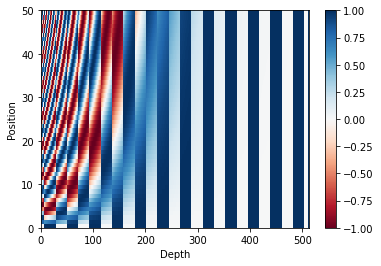

In [ ]:
# Position Encoding
print(11//2) 

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates



def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)



pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [ ]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

#example
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  # -1e9 ~ (-INFINITY) => where ever maks it set, make its logit value close to -INF

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [ ]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    print ('Attention weights are:')
    print (temp_attn)
    print ('Output is:')
    print (temp_out)

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model  # typically 512

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [ ]:
def point_wise_feed_forward_network(d_model, dff): #dff =512
    return tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
          tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
      ])

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model) # with Attention

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model) #with Attention

        return out2

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
          x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'num_layers': self.num_layers,
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dff': self.dff,
            'input_vocab_size':self.input_vocab_size,
            'maximum_position_encoding':self.maximum_position_encoding,
            'rate':self.rate
        })
        return config

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training,look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'num_layers': self.num_layers,
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dff': self.dff,
            'target_vocab_size':self.target_vocab_size,
            'maximum_position_encoding':self.maximum_position_encoding,
            'rate':self.rate
        })
        return config

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'num_layers': self.num_layers,
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dff': self.dff,
            'input_vocab_size':self.input_vocab_size,
            'target_vocab_size':self.target_vocab_size,
            'pe_input':self.pe_input,
            'pe_target':self.pe_target,
            'rate':self.rate
        })
        return config

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8


input_vocab_size = 30000
target_vocab_size = 30000
dropout_rate = 0.1

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

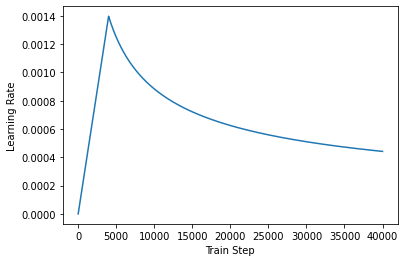

In [ ]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [ ]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [ ]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
  
  
    
    dec_padding_mask = create_padding_mask(inp)
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

In [ ]:
checkpoint_path = "./checkpoint"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [ ]:
EPOCHS = 15

In [ ]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
  
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True, 
                                     enc_padding_mask, 
                                     combined_mask, 
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()
  
    train_loss.reset_states()
    train_accuracy.reset_states()
  
  # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                             ckpt_save_path))
    
    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.6929 Accuracy 0.0841
Epoch 1 Batch 50 Loss 4.2543 Accuracy 0.0891
Epoch 1 Batch 100 Loss 4.2138 Accuracy 0.0921
Epoch 1 Batch 150 Loss 4.1654 Accuracy 0.0944
Epoch 1 Batch 200 Loss 4.1441 Accuracy 0.0954
Epoch 1 Batch 250 Loss 4.1241 Accuracy 0.0964
Epoch 1 Batch 300 Loss 4.1026 Accuracy 0.0977
Epoch 1 Batch 350 Loss 4.0994 Accuracy 0.0980
Epoch 1 Batch 400 Loss 4.0967 Accuracy 0.0982
Epoch 1 Batch 450 Loss 4.0957 Accuracy 0.0984
Epoch 1 Batch 500 Loss 4.0908 Accuracy 0.0985
Epoch 1 Batch 550 Loss 4.0849 Accuracy 0.0987
Epoch 1 Batch 600 Loss 4.0789 Accuracy 0.0991
Epoch 1 Batch 650 Loss 4.0760 Accuracy 0.0994
Epoch 1 Batch 700 Loss 4.0761 Accuracy 0.0994
Epoch 1 Batch 750 Loss 4.0757 Accuracy 0.0995
Epoch 1 Batch 800 Loss 4.0771 Accuracy 0.0996
Epoch 1 Batch 850 Loss 4.0775 Accuracy 0.0997
Epoch 1 Batch 900 Loss 4.0770 Accuracy 0.0997
Epoch 1 Batch 950 Loss 4.0814 Accuracy 0.0996
Epoch 1 Batch 1000 Loss 4.0823 Accuracy 0.0997
Epoch 1 Batch 1050 Loss 4.0856 Accur

In [ ]:
ckpt_save_path = ckpt_manager.save()

In [ ]:
print(ckpt_manager.checkpoints)

['./checkpoint/ckpt-1', './checkpoint/ckpt-2', './checkpoint/ckpt-3', './checkpoint/ckpt-4', './checkpoint/ckpt-5']


In [ ]:
def evaluate(inp_sentence):

    inp_sentence = tokenizer_func.encode("[CLS]"+inp_sentence+"[SEP]").ids
    encoder_input = tf.expand_dims(inp_sentence, 0)
  

    decoder_input = tokenizer_doc.encode("[CLS]").ids
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(50):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)

        predictions, attention_weights = transformer(encoder_input, 
                                                     output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)

        predictions = predictions[: ,-1:, :]  

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if predicted_id == 3:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [ ]:
def translate(sentence, plot=''):
    result, attention_weights = evaluate(sentence)
  
    predicted_sentence = tokenizer_doc.decode([i for i in result 
                                            if i < 30000])  

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))

In [ ]:
x=pd.read_csv('./drive/MyDrive/CS657 IR PROJECT/function_tokens.txt',names=['functions'])
y = pd.read_csv('./drive/MyDrive/CS657 IR PROJECT/docstrings.txt',names=['docstrings'])

In [ ]:
translate(x['functions'][72])
print ("Real translation: ",y['docstrings'][72])

Input: getrect self return self self self self
Predicted translation: return the number of items in the current window.
Real translation:  Returns the window bounds as a tuple of ( x y w h )


In [ ]:
translate(x['functions'][20998])
print ("Real translation: ",y['docstrings'][20999])

Input: apply object args none kwargs none if args is none args if kwargs is none kwargs return object args kwargs
Predicted translation: apply a function to a list of objects.
Real translation:  Make new Term from an Pauli operator


In [4]:
test_df = pd.read_csv("drive/MyDrive/CS657 IR PROJECT/test_sorted.csv")

In [ ]:
translate(test_df['function_tokens'][69])
print ("Real translation: ",test_df['docstring_tokens'][69])

In [ ]:
input_functions=pd.read_csv('/content/drive/MyDrive/CS657 IR PROJECT/function_tokens.txt',names=['functions'])

In [ ]:
import fileinput
import sys

In [ ]:
from contextlib import closing

n_features = 768
def read_csv():

    with closing(fileinput.input(files=('./embeddings/avg_embeddings1.tsv', './embeddings/avg_embeddings2.tsv','./embeddings/avg_embeddings3.tsv','./embeddings/avg_embeddings4.tsv'))) as finput:
        for index,line in enumerate(finput):
            record = line.rstrip().split('\t')
            features = [float(n) for n in record]
            function = tokenizer_func.encode(input_functions['functions'].values[index]).ids
            yield function,features

def get_dataset():
    generator = lambda: read_csv()
    return tf.data.Dataset.from_generator(
        generator, (tf.int32,tf.float32), ((None,),(768)))

In [ ]:
d = get_dataset()

In [ ]:

def filter_max_length(x, y):
    return tf.logical_and(tf.size(x) <= 300, tf.size(y) <= 1000)

In [ ]:

train_dataset = d
train_dataset = train_dataset.filter(filter_max_length)
print(train_dataset)

BATCH_SIZE = 128
train_dataset = train_dataset.padded_batch(BATCH_SIZE,padded_shapes=((None,), (768,)))

In [ ]:

print(11//2) 

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates



def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  

    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)



pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [ ]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    return seq[:, tf.newaxis, tf.newaxis, :] 

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)  
  

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9) 

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) 

    output = tf.matmul(attention_weights, v)  

    return output, attention_weights

In [ ]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    print ('Attention weights are:')
    print (temp_attn)
    print ('Output is:')
    print (temp_out)

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model  

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  
        k = self.wk(k)  
        v = self.wv(v)  

        q = self.split_heads(q, batch_size)  
        k = self.split_heads(k, batch_size)  
        v = self.split_heads(v, batch_size)  


        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  

        output = self.dense(concat_attention)  

        return output, attention_weights

In [ ]:
def point_wise_feed_forward_network(d_model, dff): 
    return tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),  
          tf.keras.layers.Dense(d_model)  
      ])

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  

        ffn_output = self.ffn(out1)  
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  

        return out2

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        x = self.embedding(x)  
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x 
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'num_layers': self.num_layers,
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dff': self.dff,
            'input_vocab_size':self.input_vocab_size,
            'maximum_position_encoding':self.maximum_position_encoding,
            'rate':self.rate
        })
        return config

In [ ]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  

In [ ]:

class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_vocab_size, pe_input, rate)
        self.lstm = tf.keras.layers.LSTM(1000)
        
        self.final_layer = tf.keras.layers.Dense(768)
    
    def call(self, inp, training, enc_padding_mask):

        enc_output = self.encoder(inp, training, enc_padding_mask)  
        lstm_output = self.lstm(enc_output)
        final_output = self.final_layer(lstm_output)  
        return final_output

In [ ]:
sample_transformer = Transformer(num_layers=2, d_model=512, num_heads=8, dff=2048,input_vocab_size=8500,pe_input=10000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)

fn_out = sample_transformer(temp_input, training=False,enc_padding_mask=None)

fn_out.shape  

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8


input_vocab_size = 30000
dropout_rate = 0.1

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [ ]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:

loss_object = tf.keras.losses.CosineSimilarity(axis=1)

In [ ]:

def loss_function(real, pred):
    loss = loss_object(real, pred)

    return loss

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')

In [ ]:
modified_transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, 
                          pe_input=input_vocab_size, 
                          rate=dropout_rate)

In [ ]:

def create_masks(inp):
    enc_padding_mask = create_padding_mask(inp)
  
    return enc_padding_mask

In [ ]:
checkpoint_path = "./final"

ckpt = tf.train.Checkpoint(modified_transformer=modified_transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [ ]:
EPOCHS = 15

In [ ]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.float32),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    
    enc_padding_mask = create_masks(inp)
  
    with tf.GradientTape() as tape:
        predictions = modified_transformer(inp, 
                                     True, 
                                     enc_padding_mask)
        loss = loss_function(tar, predictions)

    gradients = tape.gradient(loss, modified_transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, modified_transformer.trainable_variables))
  
    train_loss(loss)

In [ ]:

modified_transformer.layers[0].set_weights(transformer.layers[0].get_weights())

In [ ]:

modified_transformer.layers[0].trainable = False

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()
  
    train_loss.reset_states()

    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, train_loss.result()))
      
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                             ckpt_save_path))
    
    print ('Epoch {} Loss {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), ))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

In [ ]:
def generate_embeddings(inp_sentence):
    encoder_input = tf.expand_dims(inp_sentence, 0) 
    enc_padding_mask, = create_masks(encoder_input) 
    predictions = modified_transformer(encoder_input,False,enc_padding_mask) 
    return predictions[0].numpy() 

In [ ]:
inp = tokenizer_func.encode(test_df['function_tokens'][0]).ids
generate_embeddings(inp)

In [ ]:
without_docstrings = pd.read_csv('without_docstrings.csv')

In [ ]:
without_docstrings.head()

In [ ]:
func_vector = []
for i in range(len(without_docstrings['function_tokens'].values)):
    inp = tokenizer_func.encode(test_df['function_tokens'][i]).ids
    func_vector.append(generate_embeddings(inp)) 
import csv

with open("func_vectors.tsv","w+",newline='') as my_csv:
    csvWriter = csv.writer(my_csv,delimiter='\t')
    csvWriter.writerows(func_vector)

In [ ]:

from transformers import AlbertTokenizer, TFAlbertModel

albert_tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2") 

from transformers import  AlbertConfig

config = AlbertConfig.from_pretrained('./albert', output_hidden_states=True)

model = TFAlbertModel.from_pretrained('./albert', config=config,  from_pt=True)

In [ ]:
import nmslib

search_index = nmslib.init(method='hnsw', space='cosinesimil') 
e = np.loadtxt('func_vectors.tsv',delimiter='\t') 
search_index.addDataPointBatch(e) 
search_index.createIndex(print_progress=True) 

In [ ]:
def search(query):
    e = albert_tokenizer.encode(query, max_length=512) 
    input = tf.constant(e)[None, :]  
    output = model(input)
    v = [0]*768
    for i in range(1, len(input[0])-1):
        v = v + output[0][0][i].numpy()  
    emb = v/len(input[0]) 
    

    idxs, dists = search_index.knnQuery(emb, k=5) 

    for idx, dist in zip(idxs, dists):
            code = without_docstrings['original_function'][idx]  
            url = without_docstrings['url'][idx]
            print(f'cosine dist:{dist:.4f} \n {url}  \n {code} \n---------------------------------\n')

In [ ]:
search_index.saveIndex('./final.nmslib')

In [ ]:
search_index.loadIndex('./final.nmslib')

In [ ]:
search('check if process is alive')